In [1]:
import geopandas as gpd
import pyogrio as ogr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [2]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

In [4]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

In [5]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

<Axes: >

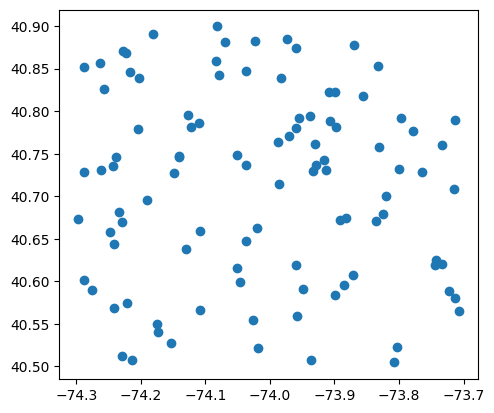

In [6]:
gdf.plot()

In [7]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


In [8]:
gdf

,geometry,neighbors
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]"
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]"
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]"
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]"
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]"
...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]"
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]"
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]"
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]"


In [9]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

In [10]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

In [11]:
gdf

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."
...,...,...,...
95,POINT (-74.19009 40.69618),"[61, 24, 57, 87, 15]","MULTILINESTRING ((-74.19009 40.69618, -74.2337..."
96,POINT (-73.94809 40.59097),"[33, 50, 91, 83, 1]","MULTILINESTRING ((-73.94809 40.59097, -73.9589..."
97,POINT (-74.28794 40.60174),"[75, 69, 67, 15, 92]","MULTILINESTRING ((-74.28794 40.60174, -74.2764..."
98,POINT (-73.80264 40.52321),"[66, 8, 52, 72, 1]","MULTILINESTRING ((-73.80264 40.52321, -73.8074..."


In [12]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

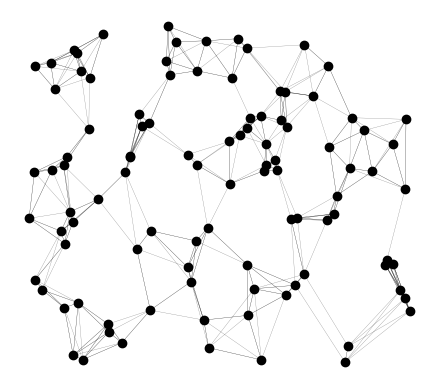

In [13]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black").set_axis_off()
plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

<Axes: >

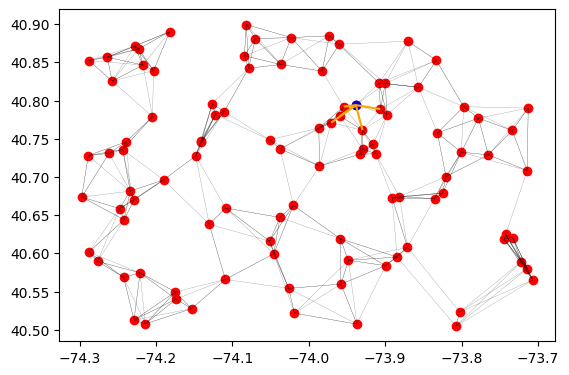

In [19]:
# plot the lines for a single point
s = gdf.sample(1)
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

# real-world example


## get restaurants in Morningside Heights


In [22]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
)

<Response [200]>

In [25]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

[{'camis': '50142894',
  'dba': 'MANHATTAN SCHOOL OF MUSIC',
  'boro': 'Manhattan',
  'building': '120',
  'street': 'CLAREMONT AVENUE',
  'zipcode': '10027',
  'phone': '7043285184',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-07-25T06:00:13.000',
  'latitude': '40.812468880147',
  'longitude': '-73.961930662882',
  'community_board': '109',
  'council_district': '07',
  'census_tract': '021100',
  'bin': '1076684',
  'bbl': '1019930001',
  'nta': 'MN09'},
 {'camis': '50153487',
  'dba': 'SUMA SUSHI',
  'boro': 'Manhattan',
  'building': '964',
  'street': 'AMSTERDAM AVENUE',
  'zipcode': '10025',
  'phone': '2122808001',
  'inspection_date': '1900-01-01T00:00:00.000',
  'critical_flag': 'Not Applicable',
  'record_date': '2024-07-25T06:00:13.000',
  'latitude': '40.801328950729',
  'longitude': '-73.965065024806',
  'community_board': '107',
  'council_district': '07',
  'census_tract': '019500',
  'bin': '1056658',
  'b

In [23]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

In [24]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [26]:
mh_restaurants.fillna("na", inplace=True)

In [27]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'inspection_date', 'critical_flag', 'record_date', 'latitude',
       'longitude', 'community_board', 'council_district', 'census_tract',
       'bin', 'bbl', 'nta', 'cuisine_description', 'action', 'violation_code',
       'violation_description', 'score', 'inspection_type', 'grade',
       'grade_date', 'geometry'],
      dtype='object')

In [28]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

In [29]:
mh_restaurants.grade.value_counts()

grade
na    78
A     69
B     10
N      8
C      3
Z      1
P      1
Name: count, dtype: int64

In [30]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          27
Coffee/Tea                        20
na                                16
Chinese                           10
Pizza                             10
Mexican                            8
Italian                            8
Japanese                           5
Juice, Smoothies, Fruit Salads     4
Sandwiches                         4
French                             4
Asian/Asian Fusion                 4
Hamburgers                         4
Ethiopian                          3
Indian                             3
Thai                               3
Other                              3
Frozen Desserts                    2
Greek                              2
Sandwiches/Salads/Mixed Buffet     2
Fusion                             2
Hawaiian                           2
Donuts                             2
Tex-Mex                            2
Latin American                     2
Mediterranean                      2
Bakery Products/De

## build graph to allow us to search


In [31]:
mh_bbox = mh_restaurants.total_bounds

In [32]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81532499])

In [39]:
mh_network = ox.graph_from_bbox(
    mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0], network_type="walk"
)

C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\307712133.py:1: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  mh_network = ox.graph_from_bbox(


In [34]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

In [41]:
mh_net_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,POINT (-73.96800 40.80140)
42421852,40.812622,-73.956823,traffic_signals,3,POINT (-73.95682 40.81262)
42421857,40.813822,-73.959800,traffic_signals,4,POINT (-73.95980 40.81382)
...,...,...,...,...,...
12029862491,40.808739,-73.965726,crossing,4,POINT (-73.96573 40.80874)
12029862492,40.808069,-73.964123,crossing,4,POINT (-73.96412 40.80807)
12029862493,40.808442,-73.965017,crossing,4,POINT (-73.96502 40.80844)


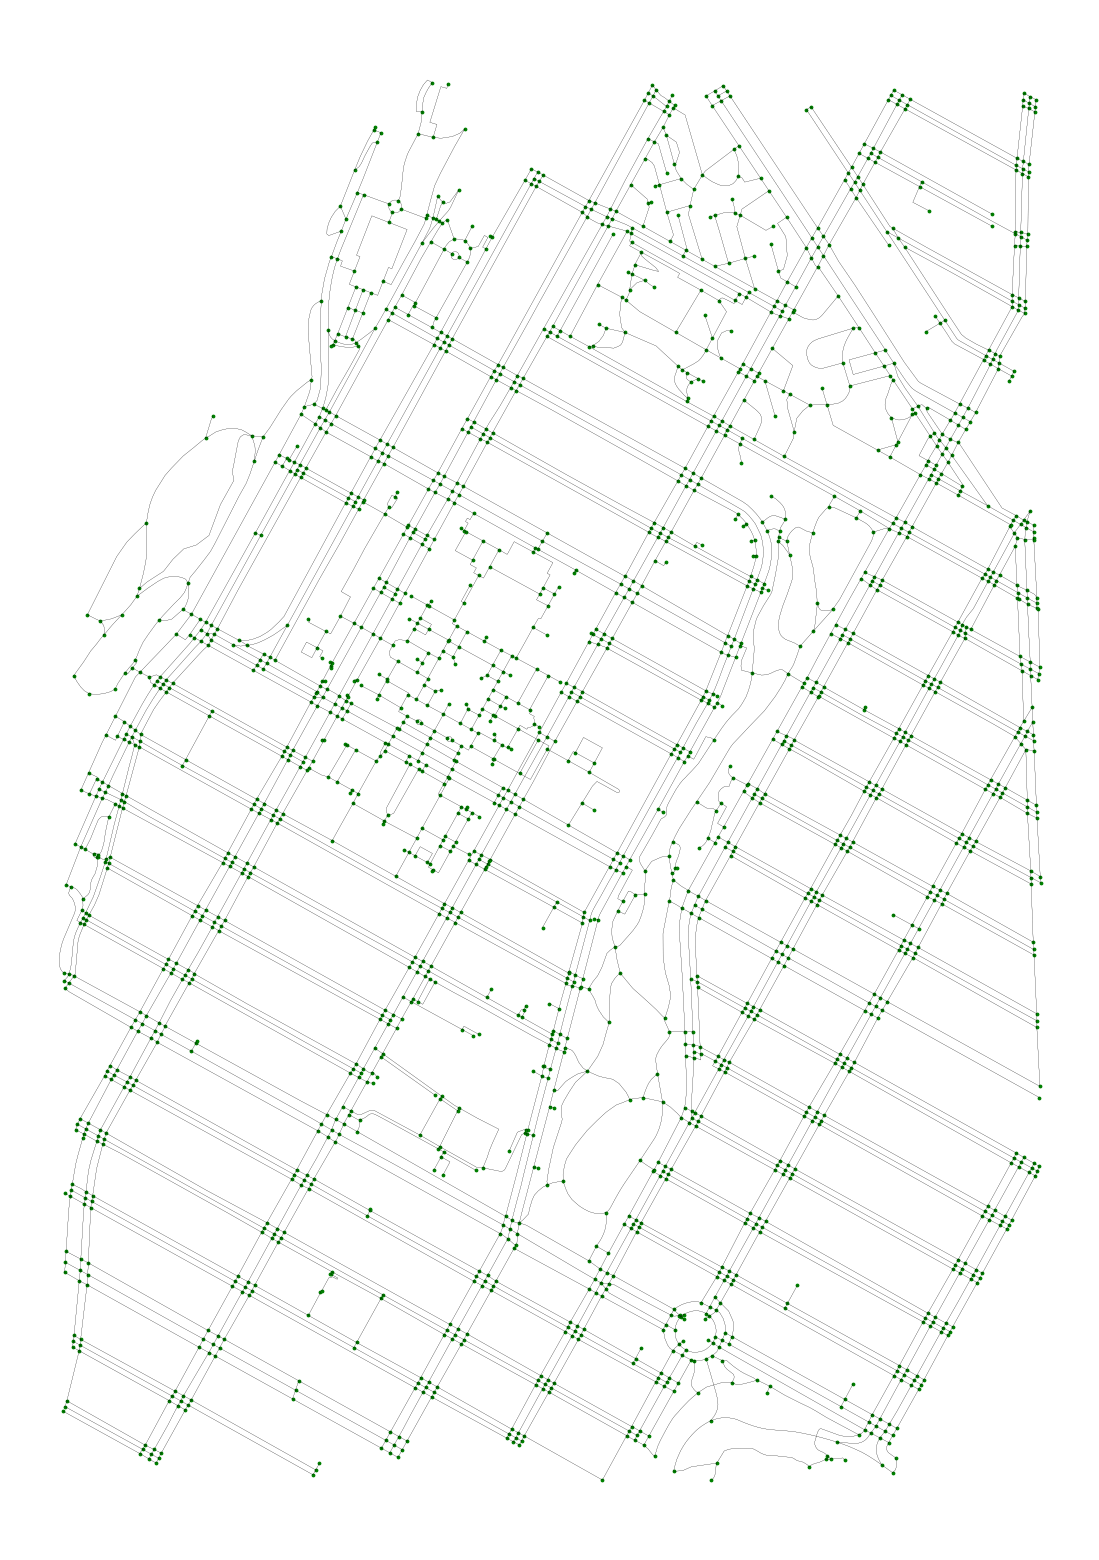

In [47]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(20, 20))
mh_net_nodes.plot(ax=ax, color="green", markersize=3).set_axis_off()

In [152]:
buell_hall = Point(-73.9637688, 40.8079964)

### get directions between avery hall and a random restaurant using osmnx


In [153]:
# get the nearest node to avery hall
orig = ox.distance.nearest_nodes(mh_network, buell_hall.x, buell_hall.y)
sample = mh_restaurants.sample(1)
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

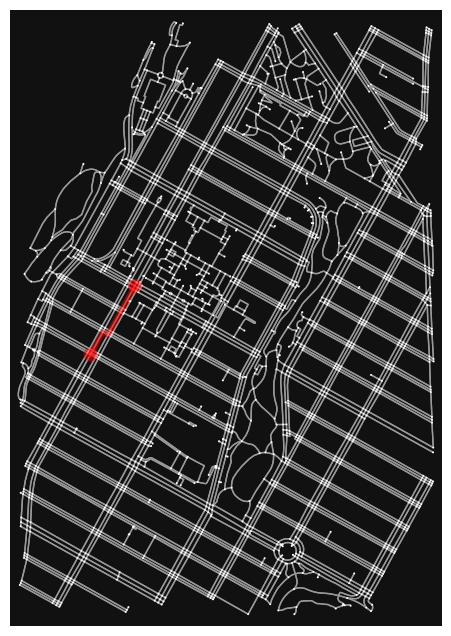

In [154]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=2)

In [157]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.16811860762797173

In [158]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

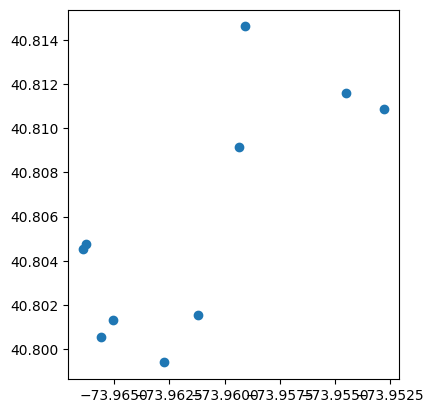

In [159]:
mh_pizza.plot()

In [160]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [161]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

c:\Users\fauxi\anaconda3\envs\cdp\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [162]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [163]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Buell Hall to \n Morningside Heights Pizza Restaurants')

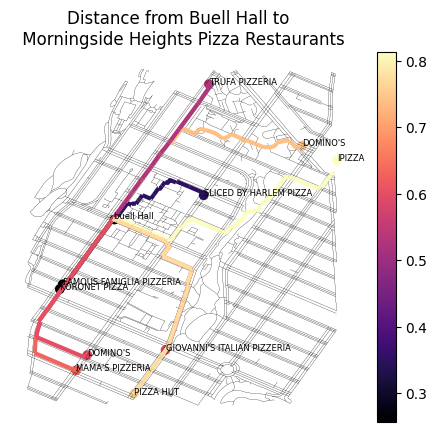

In [181]:
ax = gpd.GeoSeries(buell_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(buell_hall.x, buell_hall.y, "buell Hall", fontsize=6)

# title
plt.title("Distance from Buell Hall to \n Morningside Heights Pizza Restaurants")

In [165]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
21,FAMOUS FAMIGLIA PIZZERIA,0.256606
31,KORONET PIZZA,0.256606
161,SLICED BY HARLEM PIZZA,0.351584
329,TRUFA PIZZERIA,0.526911
144,GIOVANNI'S ITALIAN PIZZERIA,0.586933
157,DOMINO'S,0.598568
122,MAMA'S PIZZERIA,0.630084
52,DOMINO'S,0.738442
745,PIZZA HUT,0.770954
617,IPIZZA,0.812188


<Axes: >

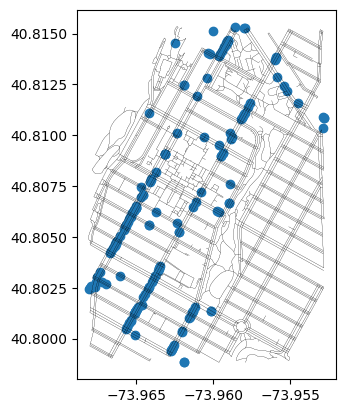

In [166]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [167]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [168]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
42421865,40.814184,-73.960693,NaN,3,"POLYGON ((-73.96259 40.81579, -73.96470 40.814...",892a1008c0fffff
42428760,40.802251,-73.967906,traffic_signals,4,"POLYGON ((-73.96646 40.80510, -73.96857 40.804...",892a1008883ffff
42428799,40.805490,-73.965860,traffic_signals,4,"POLYGON ((-73.96443 40.80780, -73.96653 40.806...",892a1008893ffff
42428844,40.811255,-73.961677,traffic_signals,3,"POLYGON ((-73.96035 40.81320, -73.96246 40.812...",892a1008c3bffff


In [169]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [170]:
mh_net_nodes["h3"]

osmid
42421737      892a10088b3ffff
42421741      892a1008887ffff
42421745      892a100888fffff
42421852      892a1008c33ffff
42421857      892a1008c07ffff
42421865      892a1008c0fffff
42428760      892a1008883ffff
42428799      892a1008893ffff
42428844      892a1008c3bffff
42429735      892a1008dcbffff
42429744      892a1008c27ffff
42429747      892a1008c23ffff
42431186      892a1008897ffff
42431193      892a100889bffff
42431203      892a1008d43ffff
42431207      892a1008d5bffff
42432917      892a1008c37ffff
42435341      892a1008d4fffff
42435343      892a1008d4bffff
42435360      892a1008c2fffff
42435763      892a1008d53ffff
42436734      892a1008cafffff
42436739      892a1008cabffff
42437918      892a10088bbffff
42441104      892a1008c77ffff
42441263      892a1008c67ffff
247225034     892a1008d47ffff
470209120     892a1008c2bffff
2141026523    892a1008d57ffff
Name: h3, dtype: object

In [171]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [172]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [173]:
mh_net_nodes.crs = "EPSG:4326"

In [174]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [175]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [176]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
42421865,40.814184,-73.960693,NaN,3,"POLYGON ((-73.96259 40.81579, -73.96470 40.814...",892a1008c0fffff
42428760,40.802251,-73.967906,traffic_signals,4,"POLYGON ((-73.96646 40.80510, -73.96857 40.804...",892a1008883ffff
42428799,40.805490,-73.965860,traffic_signals,4,"POLYGON ((-73.96443 40.80780, -73.96653 40.806...",892a1008893ffff
42428844,40.811255,-73.961677,traffic_signals,3,"POLYGON ((-73.96035 40.81320, -73.96246 40.812...",892a1008c3bffff


In [177]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

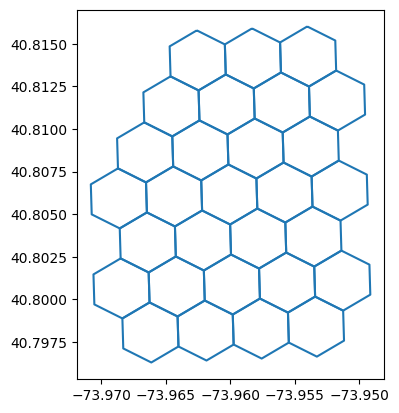

In [182]:
mh_net_nodes.boundary.plot()

<Axes: >

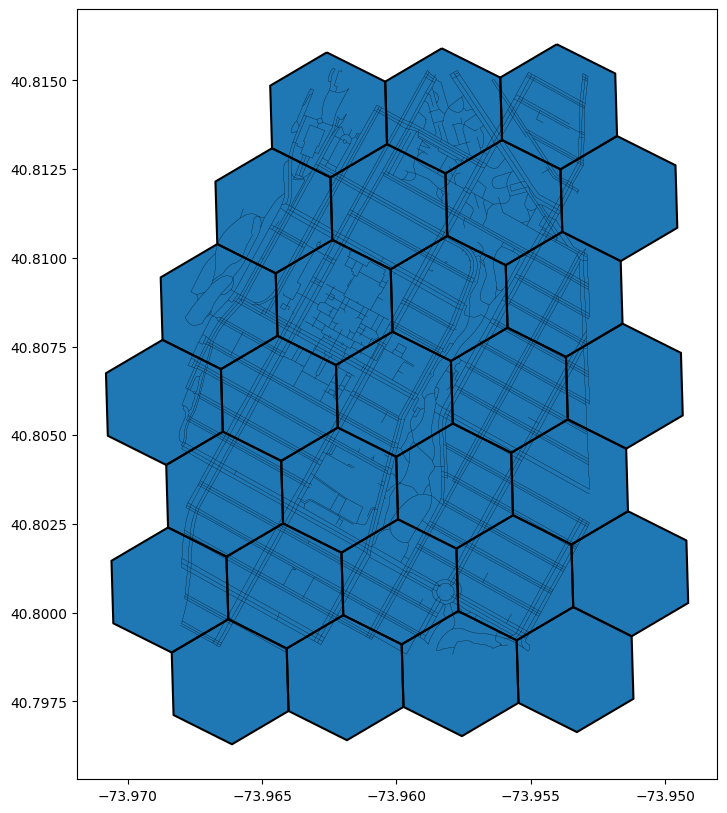

In [178]:
ax = mh_net_nodes.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [179]:
from lonboard import Map, PolygonLayer

In [180]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [87]:
mh_net_nodes.drop_duplicates(subset="h3", inplace=True)

In [88]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes)

C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\2435529990.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes)


In [89]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [90]:
neighbors

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [8, 3, 5, 22],
 5: [8, 24, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 25, 27, 12, 13],
 8: [3, 4, 5, 24, 27, 11],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 27],
 12: [1, 18, 19, 6, 7, 15],
 13: [25, 6, 7],
 14: [17, 18, 20, 26, 28, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 26, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 27, 10, 11, 12, 15],
 20: [9, 10, 28, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21],
 23: [0, 1, 2],
 24: [8, 25, 27, 5],
 25: [24, 27, 13, 7],
 26: [17, 28, 14],
 27: [19, 7, 8, 24, 11, 25],
 28: [26, 20, 14]}

In [91]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [183]:
# get the path between two nodes
path = nx.shortest_path(G, 27, 28)

C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\1576104426.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.x,
C:\Users\fauxi\AppData\Local\Temp\ipykernel_34580\1576104426.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes.geometry.centroid.y,


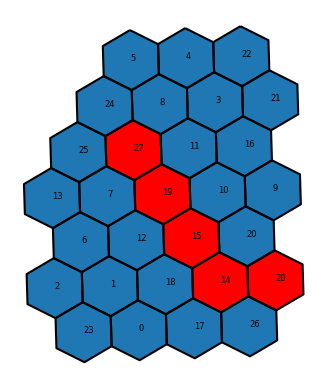

In [184]:
# plot the path
ax = mh_net_nodes.plot()
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_nodes.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes.geometry.centroid.x,
    mh_net_nodes.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)